# Tea Leaves Disease Prediction

## Importing Dataset

## Importing libraries

In [24]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import json
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## Data Preprocessing

### Training Image preprocessing

In [25]:
batch_size=32
img_height=128
img_width=128

train_dir = "/content/drive/MyDrive/Tea_Leaf_Disease"

In [26]:

data_augmentation = tf.keras.Sequential([
    tfl.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),  # Randomly flip images horizontally and vertically
    tfl.RandomRotation(factor=0.3),  # Rotate images within a 30-degree range
    tfl.RandomBrightness(factor=0.5),  # Randomly adjust brightness by up to 50%
    tfl.RandomContrast(factor=0.5),  # Randomly adjust contrast by up to 50%
    tfl.RandomZoom(height_factor=0.2, width_factor=0.2),  # Randomly zoom images in or out by up to 20%
    tfl.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images along x and y axes by up to 10%
    # tfl.Cutout(num_holes=8, max_h_size=16, max_w_size=16)  # Apply Cutout with 50% probability (TensorFlow does not have built-in Cutout)
])

In [27]:
# Normalization layer
normalization_layer = tfl.Rescaling(1./255)

In [28]:
training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    validation_split=0.1,
    subset='training',
    image_size=(128, 128),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

# Create validation dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    validation_split=0.1,
    subset='validation',
    image_size=(128, 128),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 5867 files belonging to 6 classes.
Using 5281 files for training.
Found 5867 files belonging to 6 classes.
Using 586 files for validation.


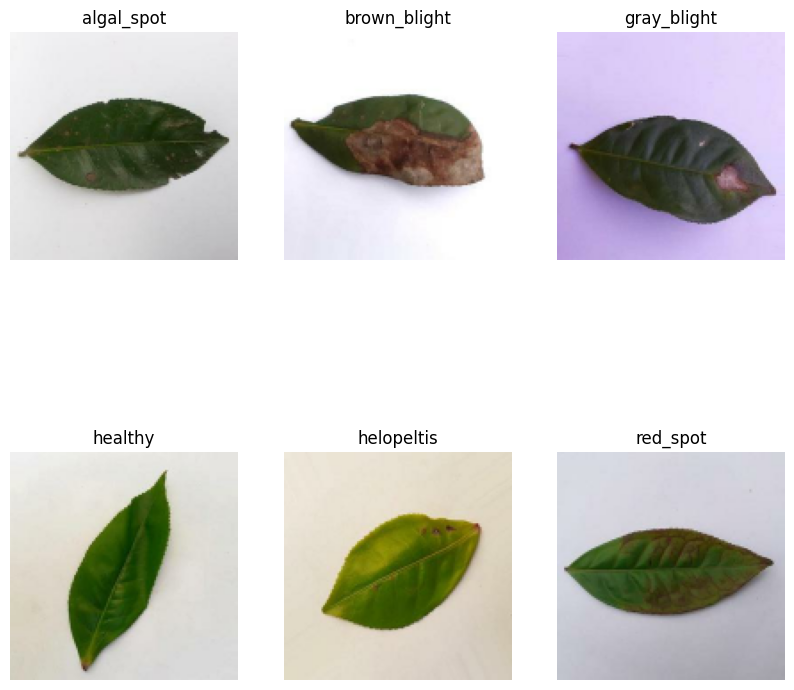

In [29]:


# Assuming 'training_set' is your training dataset
class_names = training_set.class_names
plt.figure(figsize=(10, 10))

# Dictionary to track images from each class
images_per_class = {class_name: None for class_name in class_names}
count = 0

# Unbatch the dataset and iterate over individual images and labels
for image, label in training_set.unbatch():
    class_index = np.argmax(label.numpy())  # Get the index of the class label
    class_name = class_names[class_index]

    if images_per_class[class_name] is None:  # If we don't have an image for this class yet
        images_per_class[class_name] = image.numpy()
        count += 1

    if count == len(class_names):  # If we have images for all classes
        break

# Plotting images
for i, (class_name, image) in enumerate(images_per_class.items()):
    ax = plt.subplot(2, 3, i + 1)  # 2 rows and 3 columns for 6 images
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()


In [30]:
# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

In [31]:
#Apply resizing, data augmentation, and normalization to the training set
training_set = training_set.map(resize_image)
training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))
training_set = training_set.map(lambda x, y: (normalization_layer(x), y))

# Apply resizing and normalization to the validation set
validation_set = validation_set.map(resize_image)
validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))


### Validation Image Preprocessing

#### To avoid Overshooting Loss function
1. Choose small learning rate default 0.001 here we have taken 0.0001
2. There may be chance of underfitting so increase number of neuron
3. Add more Convolutional Layer to extract more feature from images there may be possibilty that model unable to capture relevant feature or model is confusing due to lack of feature so feed with more feature

## Building Model

In [32]:

class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, window_size=4, ff_dim=256, drop_rate=0.1):
        super(SwinTransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.window_size = window_size

        # Multi-Head Attention
        self.mha = tfl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = tfl.Dropout(drop_rate)
        self.layernorm1 = tfl.LayerNormalization(epsilon=1e-6)

        # Feed-Forward Network
        self.ffn = tf.keras.Sequential([
            tfl.Dense(ff_dim, activation='relu'),
            tfl.Dense(embed_dim)
        ])
        self.dropout2 = tfl.Dropout(drop_rate)
        self.layernorm2 = tfl.LayerNormalization(epsilon=1e-6)

    def call(self, x, training):
        # Multi-Head Self Attention
        attn_output = self.mha(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # Feed-Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


### Building Convolution Layer

In [33]:

cnn = tf.keras.models.Sequential()

# Convolutional and Pooling Layers with Dilated Convolutions
cnn.add(tfl.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=[128, 128, 3]))
cnn.add(tfl.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tfl.MaxPool2D(pool_size=2, strides=2))

cnn.add(tfl.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn.add(tfl.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tfl.MaxPool2D(pool_size=2, strides=2))

cnn.add(tfl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
cnn.add(tfl.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tfl.MaxPool2D(pool_size=2, strides=2))

# Adding Dilated Convolutions
cnn.add(tfl.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', dilation_rate=2))
cnn.add(tfl.Conv2D(filters=256, kernel_size=3, activation='relu', dilation_rate=2))
cnn.add(tfl.MaxPool2D(pool_size=2, strides=2))

cnn.add(tfl.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
cnn.add(tfl.Conv2D(filters=512, kernel_size=3, activation='relu'))
cnn.add(tfl.MaxPool2D(pool_size=2, strides=2))

cnn.add(SwinTransformerBlock(num_heads=8, embed_dim=512))


# Dropout Layer
cnn.add(tfl.Dropout(0.25))

# Fully Connected Layers
cnn.add(tfl.Flatten())
cnn.add(tfl.Dense(units=1500, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
cnn.add(tfl.Dropout(0.4))  # To avoid overfitting

# Output Layer
cnn.add(tfl.Dense(units=6, activation='softmax'))

# Compile Model
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

In [34]:

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [35]:
training_history = cnn.fit(x=training_set, validation_data=validation_set, epochs=100, callbacks=[checkpoint])

Epoch 1/100
165/166 [============================>.] - ETA: 0s - loss: 8.8169 - accuracy: 0.1809
Epoch 1: val_accuracy improved from -inf to 0.26792, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 52s 264ms/step - loss: 8.8168 - accuracy: 0.1808 - val_loss: 7.8521 - val_accuracy: 0.2679
Epoch 2/100
165/166 [============================>.] - ETA: 0s - loss: 7.1868 - accuracy: 0.2788
Epoch 2: val_accuracy improved from 0.26792 to 0.27304, saving model to best_model.h5
166/166 [==============================] - 45s 266ms/step - loss: 7.1867 - accuracy: 0.2787 - val_loss: 6.5134 - val_accuracy: 0.2730
Epoch 3/100
165/166 [============================>.] - ETA: 0s - loss: 6.0562 - accuracy: 0.3280
Epoch 3: val_accuracy improved from 0.27304 to 0.31911, saving model to best_model.h5
166/166 [==============================] - 45s 261ms/step - loss: 6.0561 - accuracy: 0.3280 - val_loss: 5.5740 - val_accuracy: 0.3191
Epoch 4/100
165/166 [============================>.] - ETA: 0s - loss: 5.1762 - accuracy: 0.3830
Epoch 4: val_accuracy improved from 0.31911 to 0.47099, saving model to best_model.h5
166/166 [==============================] - 44s 26

## Evaluating Model

In [36]:
# Load the best model after training
cnn.load_weights('best_model.h5')

# You can access the best accuracy and the corresponding epoch from the training history
best_epoch = np.argmax(training_history.history['val_accuracy']) + 1
best_accuracy = np.max(training_history.history['val_accuracy'])
print(f'Best Accuracy: {best_accuracy:.4f} at epoch {best_epoch}')

Best Accuracy: 0.9590 at epoch 95


In [37]:
#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)

166/166 [==============================] - 36s 210ms/step - loss: 0.2590 - accuracy: 0.9121
Training accuracy: 0.9121378660202026


In [38]:
#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

19/19 [==============================] - 2s 57ms/step - loss: 0.1637 - accuracy: 0.9590
Validation accuracy: 0.9590443968772888


### Saving Model

In [39]:
cnn.save('trained_plant_disease_model.keras')

In [40]:
training_history.history #Return Dictionary of history

{'loss': [8.816791534423828,
  7.1866655349731445,
  6.056130886077881,
  5.176108360290527,
  4.5248494148254395,
  3.9375314712524414,
  3.5091958045959473,
  3.123318672180176,
  2.768206834793091,
  2.437905788421631,
  2.2168185710906982,
  1.9172172546386719,
  1.7237358093261719,
  1.530829668045044,
  1.4032092094421387,
  1.2903573513031006,
  1.1949108839035034,
  1.1065312623977661,
  1.0290520191192627,
  1.0027024745941162,
  0.9014163017272949,
  0.8807624578475952,
  0.8369100689888,
  0.7691417932510376,
  0.7516400814056396,
  0.7138846516609192,
  0.6946862936019897,
  0.727990984916687,
  0.635487973690033,
  0.6250938177108765,
  0.5947660803794861,
  0.5817413330078125,
  0.5384949445724487,
  0.5190554261207581,
  0.5664259195327759,
  0.5271978378295898,
  0.5193906426429749,
  0.4987887144088745,
  0.6032181978225708,
  0.5008983612060547,
  0.49147891998291016,
  0.5552747249603271,
  0.484390527009964,
  0.4376792013645172,
  0.4467233121395111,
  0.4680703282

In [41]:
#Recording History in json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [42]:
print(training_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Accuracy Visualization

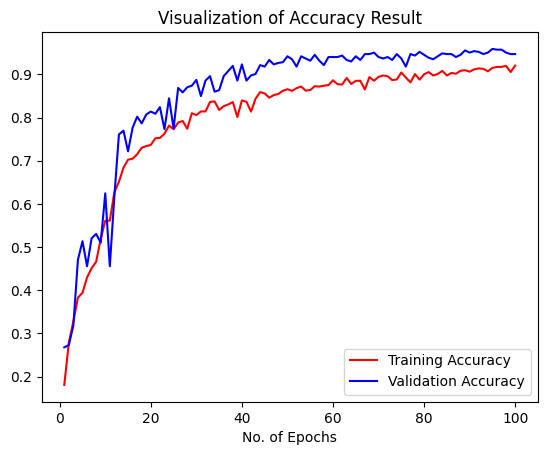

In [43]:
epochs = [i for i in range(1, len(training_history.history['accuracy']) + 1)]
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

19/19 [==============================] - 1s 22ms/step


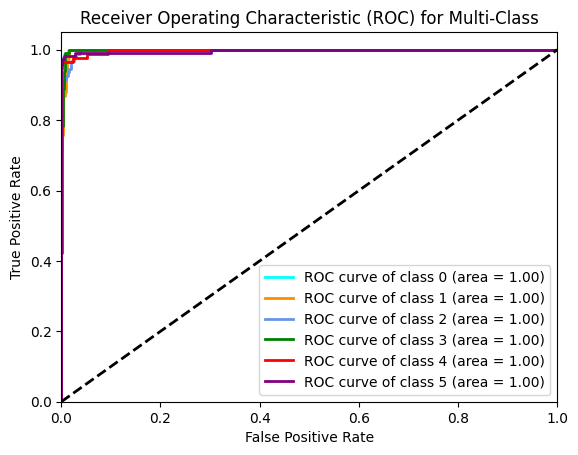

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Extract the true labels and the data from the validation set
def get_labels_and_data(dataset):
    data = []
    labels = []
    for images, lbls in dataset:
        data.append(images)
        labels.append(lbls)
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    return data, labels

# Extract data and labels
val_data, y_true = get_labels_and_data(validation_set)

# Make predictions on the validation set
y_pred = cnn.predict(val_data)

# Binarize the true labels for multi-class ROC computation
y_true = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [45]:
# Load test set
test_set = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False
)

y_pred = cnn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

Found 5867 files belonging to 6 classes.
5867/5867 [==============================] - 44s 8ms/step


              precision    recall  f1-score   support

  algal_spot       0.89      0.66      0.76      1000
brown_blight       0.89      0.98      0.93       867
 gray_blight       0.98      0.85      0.91      1000
     healthy       0.69      1.00      0.82      1000
  helopeltis       0.97      0.94      0.95      1000
    red_spot       0.99      0.89      0.94      1000

    accuracy                           0.88      5867
   macro avg       0.90      0.89      0.88      5867
weighted avg       0.90      0.88      0.88      5867



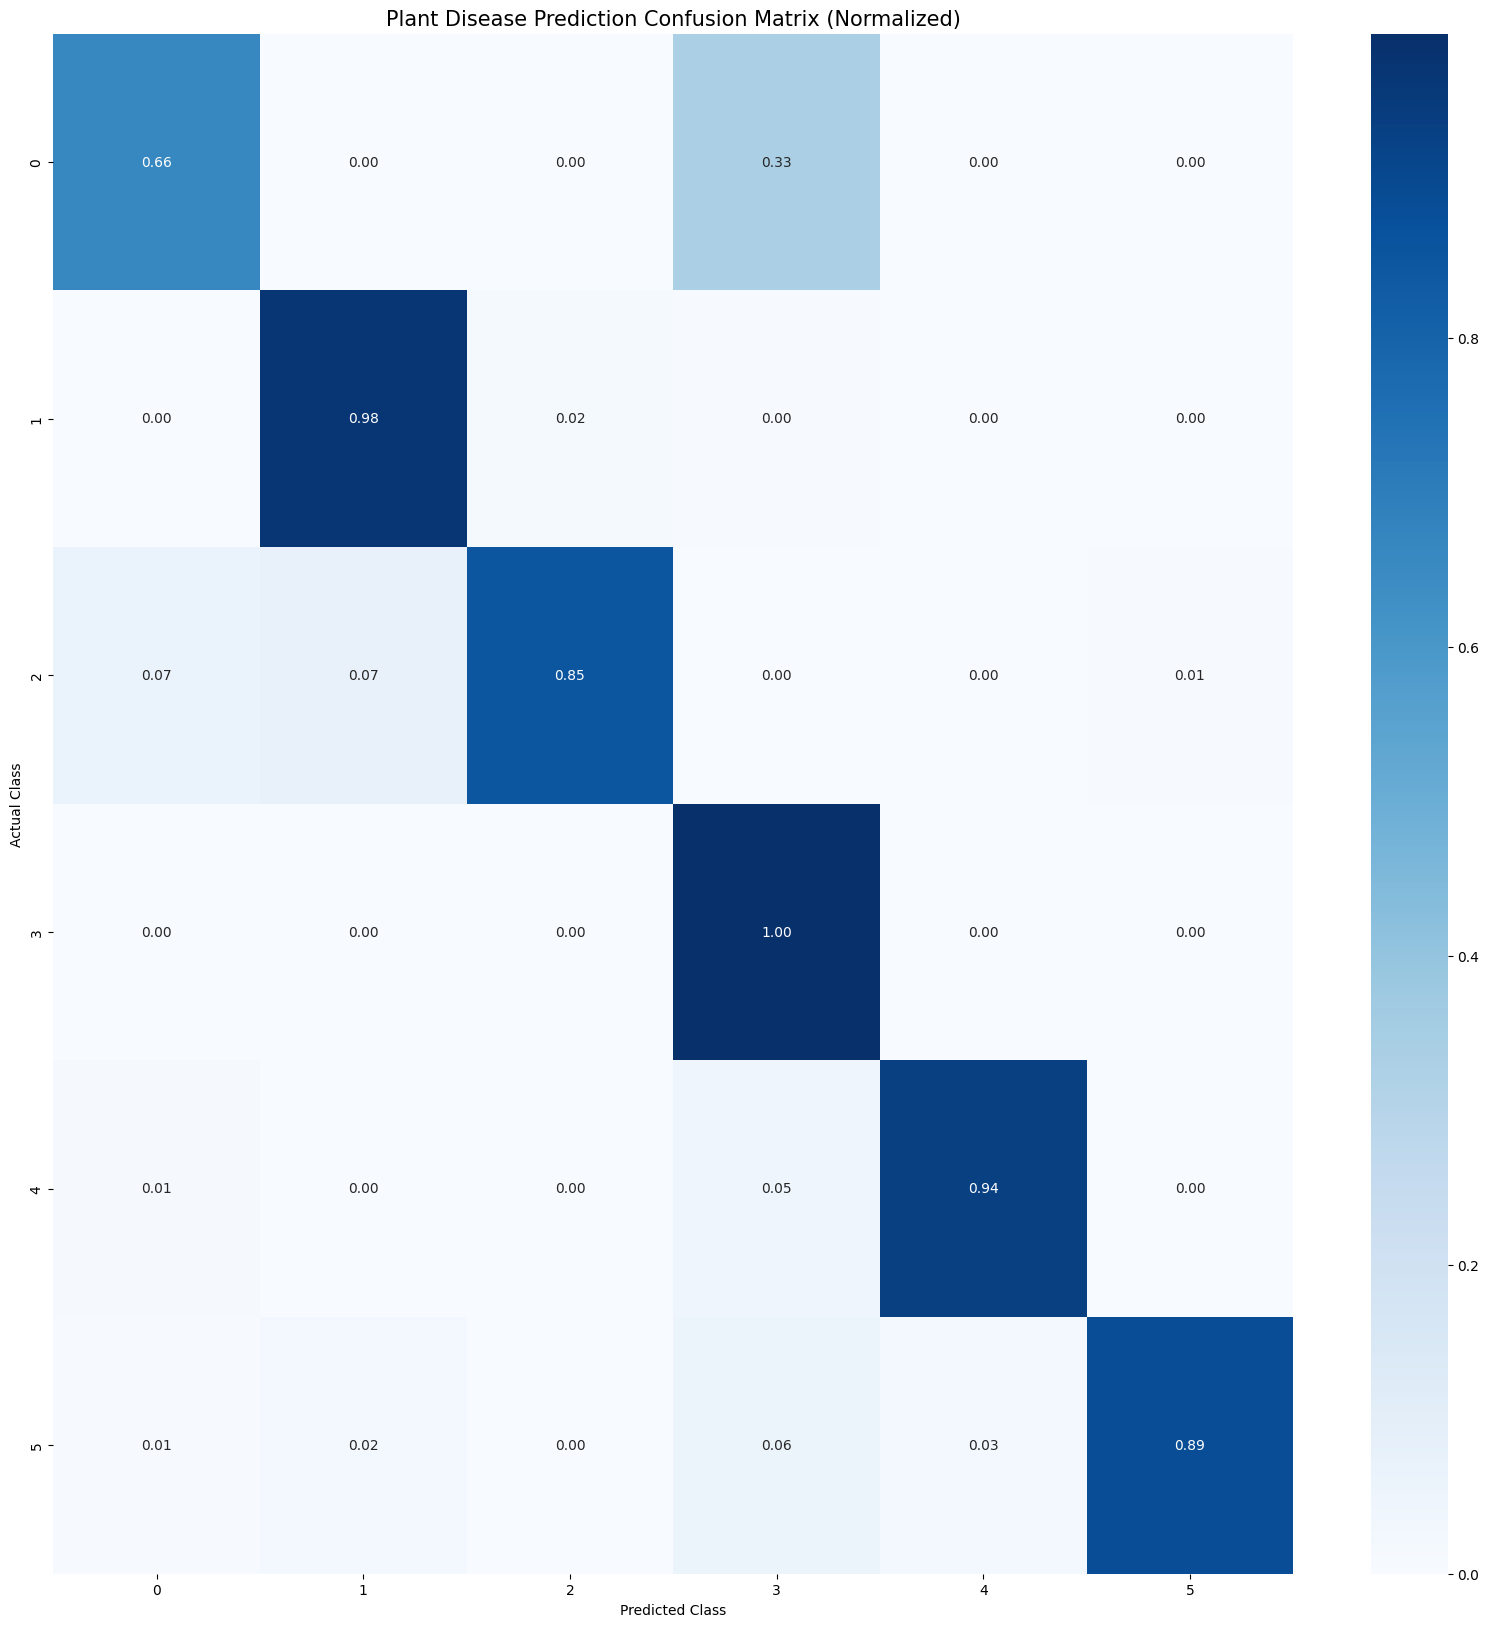

In [46]:

# Confusion Matrix and Classification Report
cm = confusion_matrix(Y_true, predicted_categories)
print(classification_report(Y_true, predicted_categories, target_names=class_names))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt='.2f')

plt.xlabel('Predicted Class', fontsize=10)
plt.ylabel('Actual Class', fontsize=10)
plt.title('Plant Disease Prediction Confusion Matrix (Normalized)', fontsize=15)
plt.show()
